In [1]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units

from BASE9Analysis import readGaiaData
from BASE9Analysis import findSeparation
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import font_manager
#point to font directory and find files within it
font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
#add fonts
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
# set font
plt.rcParams['font.family'] = 'Noto Sans JP'

%matplotlib inline

In [2]:
# %load_ext autoreload
# %autoreload 2
# from getGaiaData import GaiaClusterMembers

In [3]:
# cluster = GaiaClusterMembers(295.3250, 40.19, 1)
# cluster.verbose = 1
# cluster.getData()

In [4]:
# cluster.saveDataToFile('clusterGaiaData.ecsv')

In [5]:
#read data from ecsv and round to 4 decimals
originalGaia=readGaiaData('M67data.ecsv')
originalGaia=originalGaia.round(4)

In [6]:
#define filepaths for samplemasses, memberships, and photometry
sm = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.massSamples"
mem = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.membership"
ph = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.phot"

In [7]:
#create dataframe for photometry, and define analysis columns
phot = pd.read_csv(ph, sep='\s+')
phot['m1Mean'] = -1
phot['m1Std'] = -2
phot['m2Mean'] = -3
phot['m2Std'] = -4
phot['qMean'] = -5
phot['qStd'] = -6
phot['memMean'] = -7
phot['memStd'] = -8
phot['member'] = False
phot['binary'] = False
phot

,id,G,G_BP,G_RP,g_ps,r_ps,i_ps,z_ps,y_ps,J_2M,...,m1Mean,m1Std,m2Mean,m2Std,qMean,qStd,memMean,memStd,member,binary
0,10010400015,9.9643,11.6368,8.7188,12.0640,11.9650,10.1610,9.0880,8.5260,6.758,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1,10618000016,10.0908,11.4559,8.9425,13.2814,10.9032,9.0598,8.5864,8.8477,7.240,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
2,10719500017,10.1428,11.4292,9.0287,99.9000,99.9000,99.9000,99.9000,99.9000,7.356,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
3,11321600029,10.9064,11.7692,10.0000,99.9000,99.9000,99.9000,99.9000,99.9000,8.723,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
4,10007800034,11.0790,11.9665,10.1455,99.9000,99.9000,99.9000,99.9000,99.9000,8.819,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1905,10639026771,20.4824,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.900,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1906,10095627116,20.5168,99.9000,99.9000,21.0998,99.9000,20.2313,99.9000,99.9000,99.900,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1907,10130227255,20.5313,99.9000,99.9000,99.9000,20.5410,20.3388,99.9000,99.9000,99.900,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False
1908,10572927462,20.5560,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,99.9000,16.851,...,-1,-2,-3,-4,-5,-6,-7,-8,False,False


In [8]:
# get the IDs for the samplemasses
massIDs = np.loadtxt(sm,max_rows = 1, dtype=str)
massIDs = np.char.replace(massIDs,'mass','')
massIDs = np.char.replace(massIDs,'ratio','')
massIDs = np.char.replace(massIDs,'"','')
massIDs = (massIDs[massIDs != '']) 
massIDs

array(['10010400015', '10010400015', '10618000016', ..., '10130227255',
       '10572927462', '10572927462'], dtype='<U11')

In [9]:
samplemassWithoutHeader = np.loadtxt(sm, skiprows=1)
samplemassWithoutHeader = np.savetxt("smNoHeader.txt", samplemassWithoutHeader)

In [10]:
tempmasses = np.loadtxt(sm, max_rows=1,dtype=str, delimiter='"')
#tempmasses = np.char.replace(tempmasses,'"','')
#tempmasses = np.char.replace(tempmasses,"mass", "mass")
tempmasses= np.delete(tempmasses, 0)
# print(tmasses)
# print(tempmasses)
tempmasseslist = tempmasses.tolist()
#print(tempmasseslist)
pdmasses = pd.read_csv(r"/Users/Claire/Documents/Code/current/ANNACRNN/getGaiaData/smNoHeader.txt", sep='\s+', header=None, names=tempmasseslist)
#pdmasses = pdmasses.drop(index=0)
#pdmasses.rename(tempmasseslist)
pdmasses

,10010400015 mass,10010400015 ratio,10618000016 mass,10618000016 ratio,10719500017 mass,10719500017 ratio,11321600029 mass,11321600029 ratio,10007800034 mass,10007800034 ratio,...,10032126671 mass,10032126671 ratio,10639026771 mass,10639026771 ratio,10095627116 mass,10095627116 ratio,10130227255 mass,10130227255 ratio,10572927462 mass,10572927462 ratio
0,1.574868,0.020599,1.574715,0.029794,1.603483,0.016536,1.602885,0.011170,1.572956,0.001209,...,0.527695,0.969877,0.518755,0.998912,0.612674,0.187824,0.585406,0.010039,0.525684,0.969673
1,1.574873,0.051145,1.603571,0.026631,1.574496,0.069956,1.602894,0.013303,1.572939,0.011842,...,0.571135,0.741391,0.525578,0.966832,0.613024,0.037291,0.586351,0.110127,0.523238,0.975742
2,1.574871,0.102229,1.574714,0.080724,1.603479,0.011167,1.602883,0.012555,1.572963,0.004613,...,0.566511,0.767119,0.581821,0.532182,0.610889,0.092299,0.585919,0.102307,0.517756,0.991133
3,1.574867,0.040008,1.603573,0.021900,1.574494,0.019001,1.602900,0.021936,1.572953,0.167523,...,0.526926,0.965502,0.591206,0.193431,0.612917,0.124538,0.586853,0.042305,0.537362,0.899491
4,1.574878,0.023781,1.603572,0.025756,1.574509,0.118626,1.602882,0.004683,1.572946,0.039430,...,0.523081,0.991467,0.586764,0.447200,0.611353,0.114092,0.587364,0.036435,0.513124,0.989796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9336,1.575326,0.008638,1.575190,0.020791,1.574969,0.002490,1.603352,0.012972,1.573419,0.140813,...,0.595236,0.093770,0.545475,0.891631,0.612705,0.030245,0.586037,0.037472,0.519481,0.988036
9337,1.575332,0.027078,1.604037,0.030817,1.574970,0.092763,1.603355,0.026058,1.573416,0.025080,...,0.560277,0.784462,0.589911,0.134081,0.613161,0.019629,0.584940,0.110299,0.514861,0.991772
9338,1.575338,0.007795,1.575173,0.036414,1.603946,0.011933,1.603371,0.002955,1.573425,0.129995,...,0.521004,0.997775,0.540074,0.907238,0.611897,0.061687,0.586567,0.110591,0.542027,0.887160
9339,1.575336,0.000763,1.575184,0.023837,1.603947,0.000168,1.603355,0.016358,1.573427,0.041237,...,0.523577,0.999153,0.550172,0.861265,0.614893,0.066061,0.587824,0.058345,0.522946,0.968582


10229313485 mass
0.7347065


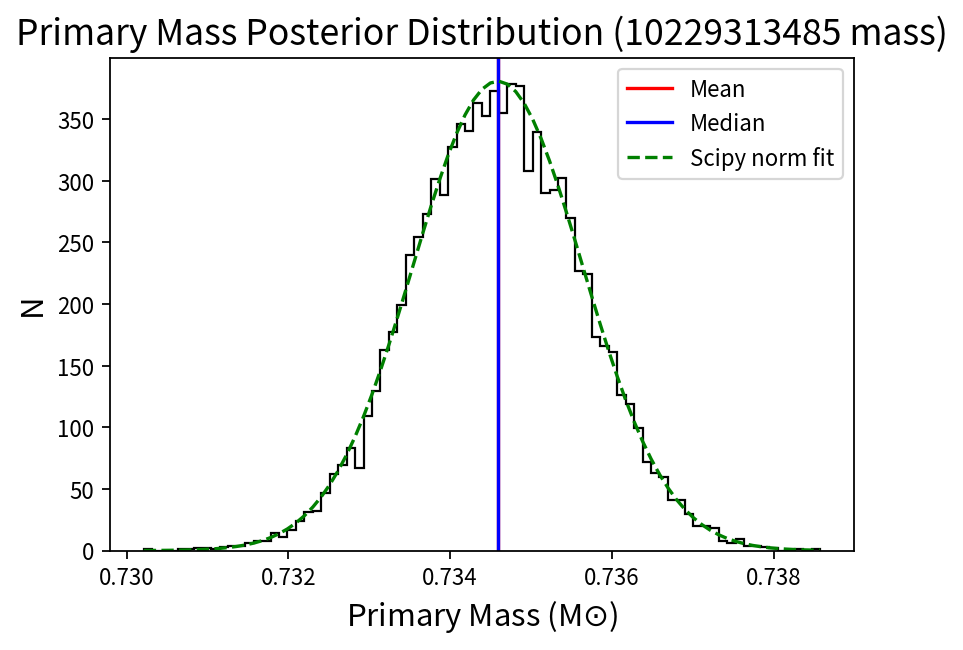

In [11]:
from astropy.modeling import models, fitting
from scipy.stats import norm
import matplotlib.mlab as mlab
import random

f,ax = plt.subplots(figsize=(6,4), facecolor='w', dpi=160)

y=pdmasses.iloc[:, ::2]
y.columns[90]

maxcol = y.shape[1]
randomStar= random.randint(0,maxcol)
randomStarName= y.columns[randomStar]

print(randomStarName)



n, bins, patches= plt.hist(pdmasses[randomStarName], bins=80, color='black', histtype = "step")
#print(n,bins)

plt.axvline(np.mean(pdmasses[randomStarName]), color="r", label='Mean')
plt.axvline(np.median(pdmasses[randomStarName]), color="b", label='Median')
plt.title(f"Primary Mass Posterior Distribution ({randomStarName})", fontsize=16)
plt.xlabel("Primary Mass (M$\odot$)", fontsize=14)
plt.ylabel("N", fontsize=14)

#fit
RVguess = bins[np.argmax(n)]
p_init = models.Gaussian1D(np.max(n), RVguess, 1)
fit_p = fitting.LevMarLSQFitter()
rvG1D = fit_p(p_init, bins[:-1], n)

mu, std = norm.fit(pdmasses[randomStarName])

best_fit_line = norm.pdf(bins, mu, std)
#print(best_fit_line)
# print(p_init)
# print(rvG1D)
plt.plot(bins, best_fit_line, 'g--', label='Scipy norm fit')
plt.legend()

print(bins[np.argmax(n)])


      10010400015 ratio  10618000016 ratio  10719500017 ratio  \
0              0.020599           0.029794           0.016536   
1              0.051145           0.026631           0.069956   
2              0.102229           0.080724           0.011167   
3              0.040008           0.021900           0.019001   
4              0.023781           0.025756           0.118626   
...                 ...                ...                ...   
9336           0.008638           0.020791           0.002490   
9337           0.027078           0.030817           0.092763   
9338           0.007795           0.036414           0.011933   
9339           0.000763           0.023837           0.000168   
9340           0.026482           0.061733           0.025745   

      11321600029 ratio  10007800034 ratio  10556700036 ratio  \
0              0.011170           0.001209           0.012238   
1              0.013303           0.011842           0.003919   
2              0.012555 

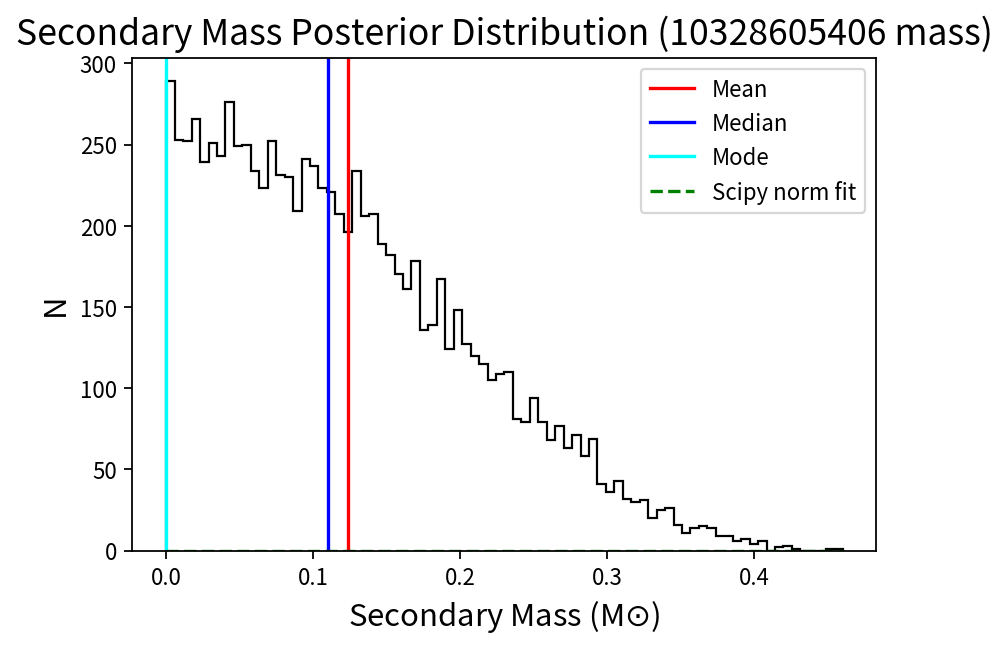

In [12]:
from astropy.modeling import models, fitting
from scipy.stats import norm
import matplotlib.mlab as mlab
import random

f,ax = plt.subplots(figsize=(6,4), facecolor='w', dpi=160) #change dpi and size later

ratios=pdmasses.iloc[:, 1::2]
primarymasses = pdmasses.iloc[:, ::2]
print(ratios)
#print(primarymass)
#print("test:",ratios.columns[90])
maxcol1 = primarymasses.shape[1]
maxcol2 = ratios.shape[1]
print(maxcol1,maxcol2)

randomStar= random.randint(0,maxcol)
randomStarNameForRatios= ratios.columns[randomStar]
randomStarNameForPrimaryMasses = primarymasses.columns[randomStar]

print(randomStarNameForRatios,randomStarNameForPrimaryMasses)

secondarymass = primarymasses[randomStarNameForPrimaryMasses]*ratios[randomStarNameForRatios]

n, bins, patches= plt.hist(secondarymass, bins=80, color='black', histtype = "step")
#print(n,bins)

plt.axvline(np.mean(secondarymass), c="r", label='Mean')
plt.axvline(np.median(secondarymass), c="b", label='Median')
plt.axvline(bins[np.argmax(n)], c='cyan', label='Mode')
plt.title(f"Secondary Mass Posterior Distribution ({randomStarNameForPrimaryMasses})", fontsize=16)
plt.xlabel("Secondary Mass (M$\odot$)", fontsize=14)
plt.ylabel("N", fontsize=14)

#fit
RVguess = bins[np.argmax(n)]
p_init = models.Gaussian1D(np.max(n), RVguess, 1)
fit_p = fitting.LevMarLSQFitter()
rvG1D = fit_p(p_init, bins[:-1], n)

mu, std = norm.fit(pdmasses[randomStarName])

best_fit_line = norm.pdf(bins, mu, std)
#print(best_fit_line)
# print(p_init)
# print(rvG1D)
plt.plot(bins, best_fit_line, 'g--', label='Scipy norm fit')
plt.legend()

print(bins[np.argmax(n)])


0       0.735945
1       0.735215
2       0.735148
3       0.733054
4       0.733622
          ...   
9336    0.734911
9337    0.735021
9338    0.734714
9339    0.734598
9340    0.734556
Name: 10229313485 mass, Length: 9341, dtype: float64


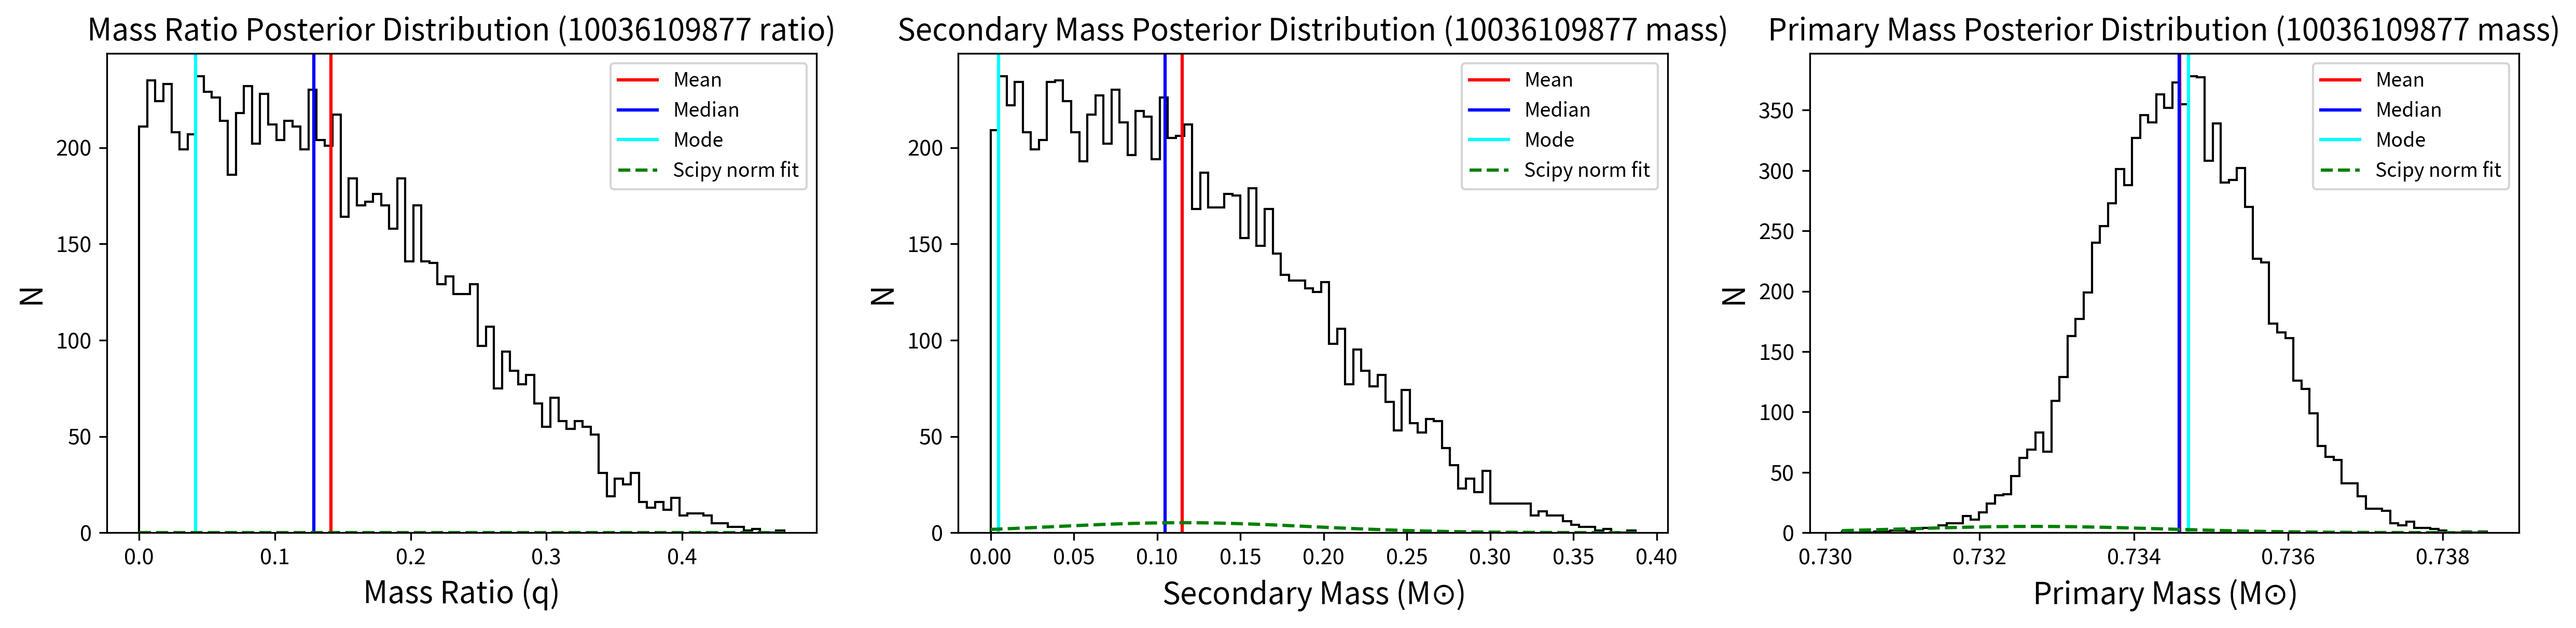

In [23]:
#all posteriors
from astropy.modeling import models, fitting
from scipy.stats import norm
import matplotlib.mlab as mlab
import random

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4), facecolor='w', dpi=300) #change dpi and size later

ratios=pdmasses.iloc[:, 1::2]
primarymasses = pdmasses.iloc[:, ::2]
#print(ratios)
#print(primarymasses)
#print("test:",ratios.columns[90])
maxcol1 = primarymasses.shape[1]
maxcol2 = ratios.shape[1]
#print(maxcol1,maxcol2)

randomStar= random.randint(0,maxcol)
randomStarNameForRatios= ratios.columns[randomStar]
randomStarNameForPrimaryMasses = primarymasses.columns[randomStar]

#print(randomStarNameForRatios,randomStarNameForPrimaryMasses)
massratio = ratios[randomStarNameForRatios]
primarymass = pdmasses[randomStarName]
secondarymass = primarymasses[randomStarNameForPrimaryMasses]*ratios[randomStarNameForRatios]

n, bins, patches = ax1.hist(massratio, bins=80, color='black', histtype = "step")
n2, bins2, patches2 = ax2.hist(secondarymass, bins=80, color='black', histtype = "step")
n3, bins3, patches3 = ax3.hist(primarymass, bins=80, color='black', histtype = "step")


ax1.axvline(np.mean(massratio), c="r", label='Mean')
ax1.axvline(np.median(massratio), c="b", label='Median')
ax1.axvline(bins[np.argmax(n)], c='cyan', label='Mode')
ax1.set_title(f"Mass Ratio Posterior Distribution ({randomStarNameForRatios})", fontsize=14)
ax1.set_xlabel("Mass Ratio (q)", fontsize=14)
ax1.set_ylabel("N", fontsize=14)

ax2.axvline(np.mean(secondarymass), c="r", label='Mean')
ax2.axvline(np.median(secondarymass), c="b", label='Median')
ax2.axvline(bins2[np.argmax(n2)], c='cyan', label='Mode')
ax2.set_title(f"Secondary Mass Posterior Distribution ({randomStarNameForPrimaryMasses})", fontsize=14)
ax2.set_xlabel("Secondary Mass (M$\odot$)", fontsize=14)
ax2.set_ylabel("N", fontsize=14)

ax3.axvline(np.mean(primarymass), c="r", label='Mean')
ax3.axvline(np.median(primarymass), c="b", label='Median')
ax3.axvline(bins3[np.argmax(n3)], c='cyan', label='Mode')
ax3.set_title(f"Primary Mass Posterior Distribution ({randomStarNameForPrimaryMasses})", fontsize=14)
ax3.set_xlabel("Primary Mass (M$\odot$)", fontsize=14)
ax3.set_ylabel("N", fontsize=14)

#fits
# RVguess = bins[np.argmax(n)]
# p_init = models.Gaussian1D(np.max(n), RVguess, 1)
# fit_p = fitting.LevMarLSQFitter()
# rvG1D = fit_p(p_init, bins[:-1], n)
print(pdmasses[randomStarName])

mu, std = norm.fit(primarymass)
mu2, std2 = norm.fit(secondarymass)
mu3, std3 = norm.fit(massratio)

best_fit_line = norm.pdf(bins, mu, std)
best_fit_line2 = norm.pdf(bins2, mu2, std2)
best_fit_line3 = norm.pdf(bins3, mu3, std3)
#print(best_fit_line)
# print(p_init)
# print(rvG1D)
ax1.plot(bins, best_fit_line, 'g--', label='Scipy norm fit')
ax2.plot(bins2, best_fit_line2, 'g--', label='Scipy norm fit')
ax3.plot(bins3, best_fit_line2, 'g--', label='Scipy norm fit')
ax1.legend(fontsize=9)
ax2.legend(fontsize=9)
ax3.legend(fontsize=9)

#print(bins[np.argmax(n)])


(array([  1.,   0.,   0.,   0.,   1.,   1.,   2.,   2.,   6.,   2.,   6.,
          6.,   4.,   9.,  10.,  17.,  17.,  20.,  26.,  48.,  64.,  87.,
        136., 168., 200., 247., 307., 362., 472., 492., 525., 563., 583.,
        525., 585., 623., 630., 552., 471., 451., 363., 270., 198., 124.,
         81.,  42.,  24.,  14.,   3.,   1.]),
 array([0.20278858, 0.20850276, 0.21421694, 0.21993111, 0.22564529,
        0.23135947, 0.23707364, 0.24278782, 0.248502  , 0.25421617,
        0.25993035, 0.26564453, 0.2713587 , 0.27707288, 0.28278706,
        0.28850124, 0.29421541, 0.29992959, 0.30564377, 0.31135794,
        0.31707212, 0.3227863 , 0.32850047, 0.33421465, 0.33992883,
        0.345643  , 0.35135718, 0.35707136, 0.36278554, 0.36849971,
        0.37421389, 0.37992807, 0.38564224, 0.39135642, 0.3970706 ,
        0.40278477, 0.40849895, 0.41421313, 0.4199273 , 0.42564148,
        0.43135566, 0.43706984, 0.44278401, 0.44849819, 0.45421237,
        0.45992654, 0.46564072, 0.4713549 , 0.

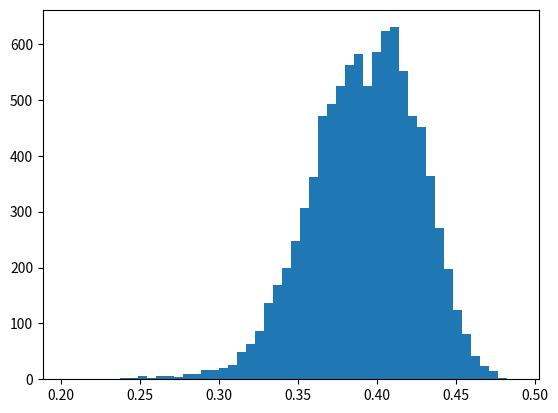

In [14]:
plt.hist(pdmasses['10000513054 mass']*pdmasses['10000513054 ratio '], bins=50)

In [15]:
# test = y.sample(axis="columns")

# print(test)
# plt.hist(test, bins=50)
# plt.axvline(np.mean(test), color="r")
# plt.axvline(np.median(test), color="g")

      10026003525 ratio
0              0.311234
1              0.038916
2              0.265517
3              0.028917
4              0.340532
...                 ...
9336           0.363579
9337           0.231477
9338           0.390072
9339           0.269762
9340           0.096201

[9341 rows x 1 columns]


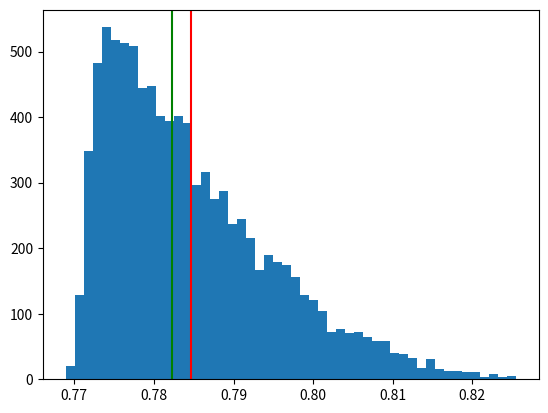

In [16]:
star = pdmasses['10053507799 mass']
test = pdmasses.sample(axis="columns")
print(test)
plt.hist(star, bins=50)
plt.axvline(np.mean(star), color="r")
plt.axvline(np.median(star), color="g")

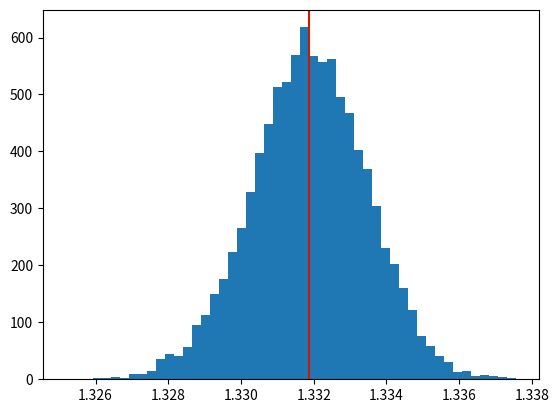

In [17]:
plt.hist(pdmasses['10004101495 mass'], bins=50)
plt.axvline(np.mean(pdmasses['10004101495 mass']), color="r")
plt.axvline(np.median(pdmasses['10004101495 mass']), color="g", alpha=0.2)

(1.42, 1.46)

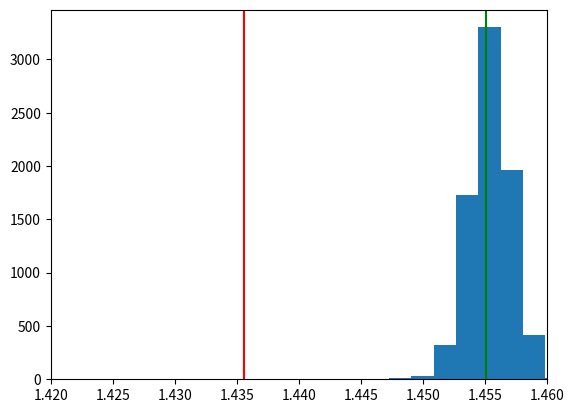

In [18]:
plt.hist(pdmasses['10029900896 mass'], bins=100)
plt.axvline(np.mean(pdmasses['10029900896 mass']), color="r")
plt.axvline(np.median(pdmasses['10029900896 mass']), color="g")
plt.xlim(1.42, 1.46)